In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import box, Polygon, LinearRing
import numpy as np
from scipy.spatial import ConvexHull
from shapely.affinity import scale, translate
import itertools

import matplotlib.pyplot as plt
import geopandas as gpd

from area_derivations import iou, minimum_bounding_rectangle, get_best_fit_rect

In [2]:
v1_ref = (60, 92)

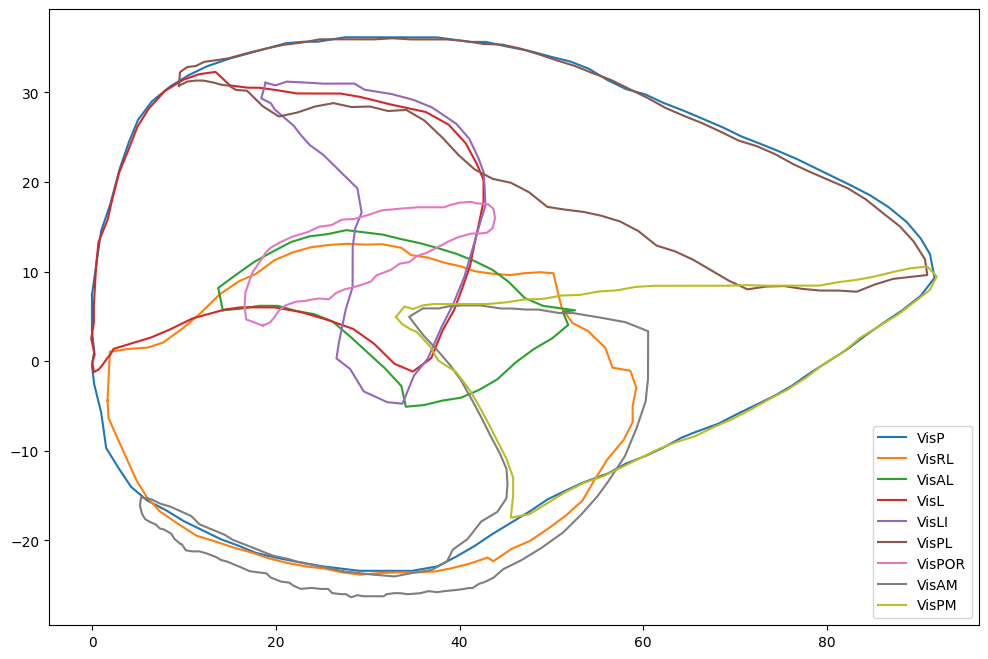

In [3]:
areas = ["VisP", "VisRL", "VisAL", "VisL", "VisLI", "VisPL", "VisPOR", "VisAM", "VisPM"]

plt.figure(figsize=(12, 8))

for area in areas:
    polygon = Polygon(pd.read_csv(f"digitized_data/{area}.csv").values)
    x, y = polygon.exterior.xy
    plt.plot(list(x), list(y), label=area)

plt.legend()
# print(pd.read_csv(f"digitized_data/VisPOR.csv").values)

In [4]:
# area_pairs = list(itertools.product([areas[0]], areas[1:]))
# area_pairs

In [5]:
bounding_rectangles = []
visp_polygon = Polygon(pd.read_csv(f"digitized_data/VisP.csv").values)
visp_bound = Polygon(minimum_bounding_rectangle(visp_polygon))

for area in areas:
    polygon = Polygon(pd.read_csv(f"digitized_data/{area}.csv").values)
    min_bounding_rect = Polygon(minimum_bounding_rectangle(polygon))
    bounding_rectangles.append(
        visp_bound.intersection(min_bounding_rect)
    )
    

In [6]:
np.array(visp_polygon.exterior.xy).T.shape

(101, 2)

In [7]:
best_rects = {}
best_ious = {}
#AM and PM don't work for some reason? Which is kind of convienent...
areas = ["VisP", "VisRL", "VisAL", "VisL", "VisLI", "VisPL", "VisPM", "VisAM", "VisPOR"]
for area in areas:
    best_rect, best_iou = get_best_fit_rect(area)
    best_rects[area] = best_rect
    best_ious[area] = best_iou

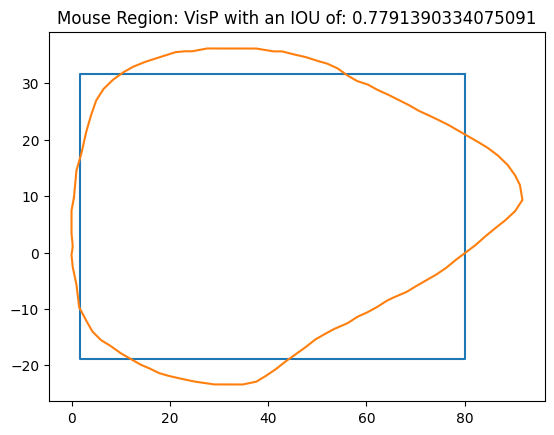

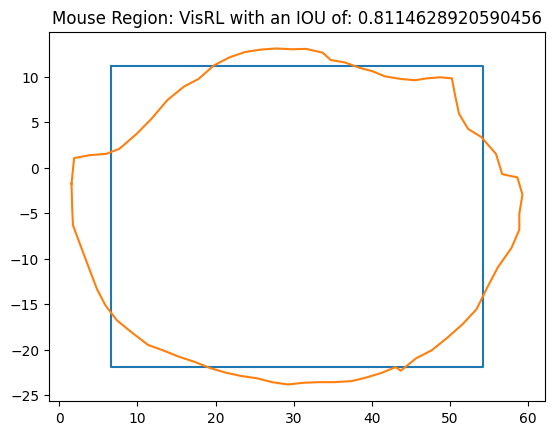

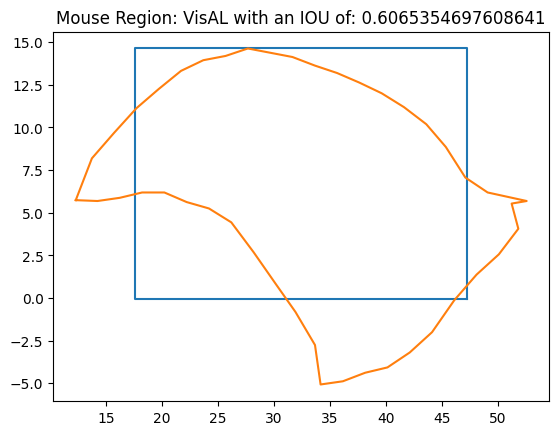

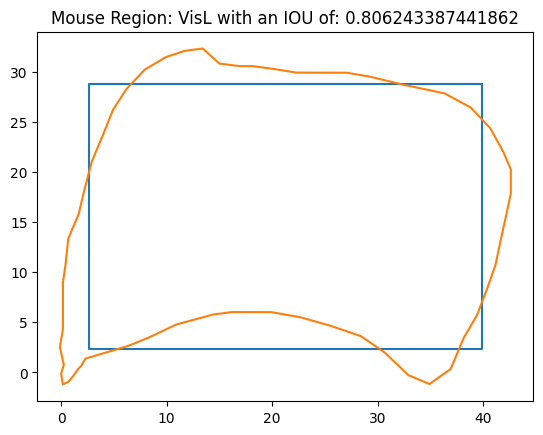

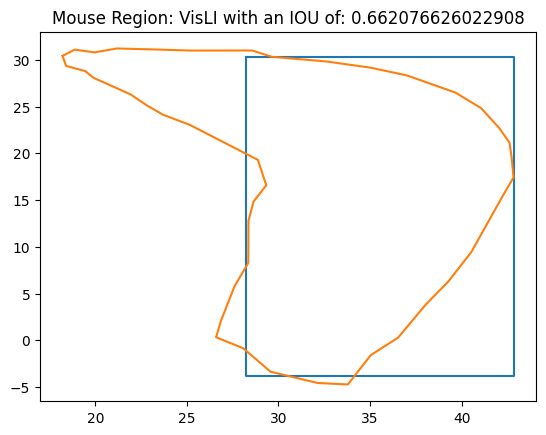

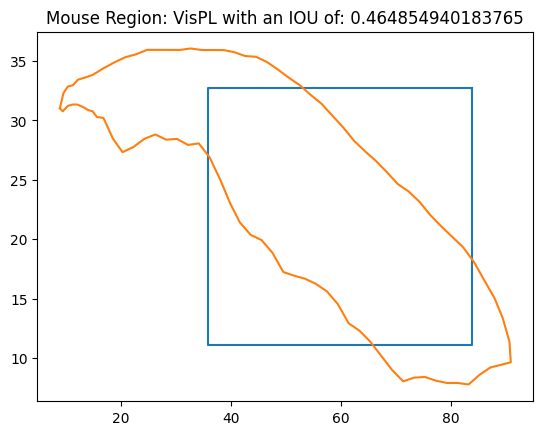

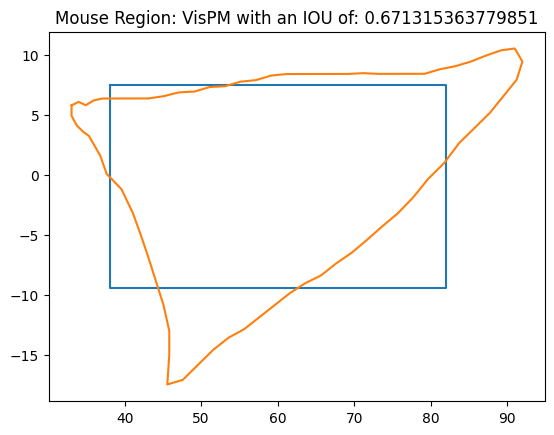

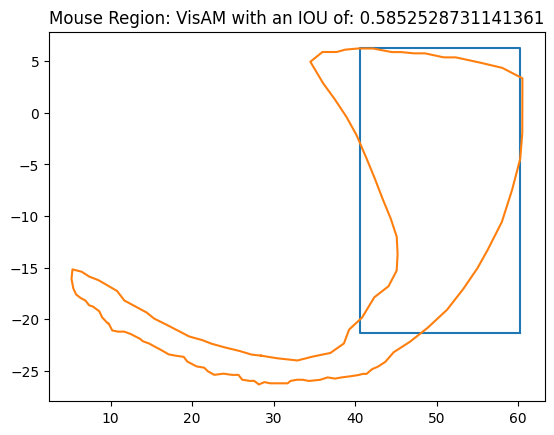

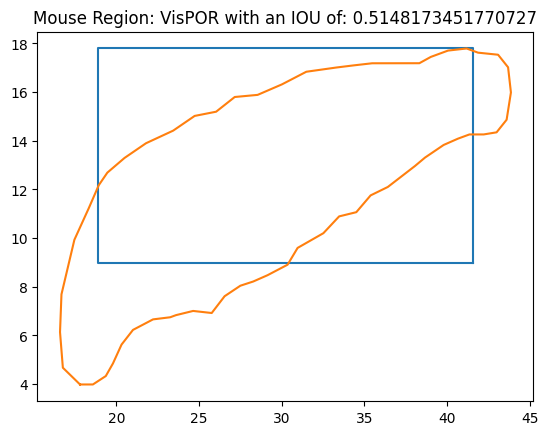

In [8]:
for area in areas:
    plt.figure()
    area_df = pd.read_csv(f"digitized_data/{area}.csv", header=None)
    area_polygon = Polygon(area_df.values)

    best_rect = best_rects[area]

    plt.plot(*best_rect.exterior.xy)
    plt.plot(*area_polygon.exterior.xy)

    plt.title(f"Mouse Region: {area} with an IOU of: {best_ious[area]}")

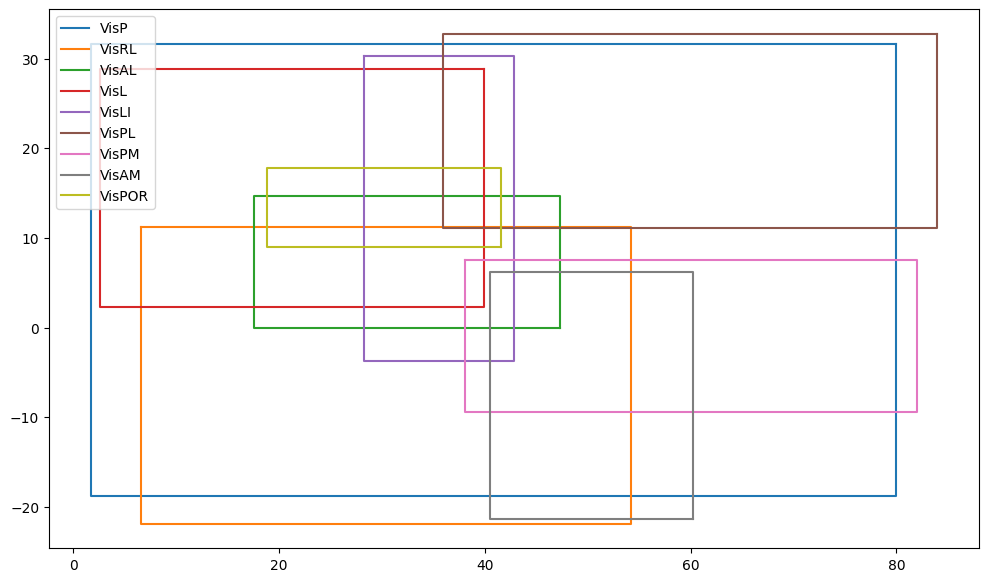

In [9]:
def plot_visareas(rectangles):
    plt.figure(figsize=(12, 7))
    for area in areas:
        # area_df = pd.read_csv(f"digitized_data/{area}.csv", header=None)
        # area_polygon = Polygon(area_df.values)
        plt.plot(*rectangles[area].exterior.xy, label=area)

    plt.legend()
plot_visareas(best_rects)

In [10]:
# Extend vis areas to cover visPOR
minx, miny, maxx, maxy = best_rects["VisPOR"].bounds
visp_minx, visp_miny, visp_maxx, visp_maxy= best_rects["VisP"].bounds
modified_rects = {}
for area in areas:
    poly_minx, poly_miny, poly_maxx, poly_maxy = best_rects[area].bounds
    poly_x1 = max(min(poly_minx, minx), visp_minx)
    poly_y1 = max(min(poly_miny, miny), visp_miny)
    poly_x2 = min(max(poly_maxx, maxx), visp_maxx)
    poly_y2 = min(max(poly_maxy, maxy), visp_maxy)
    
    polyg = Polygon(np.array([
            [poly_x1, poly_y1], [poly_x1, poly_y2], 
            [poly_x2, poly_y2], [poly_x2, poly_y1]])
        )
    # polyg = best_rects[area]
    modified_rects[area]=polyg
    

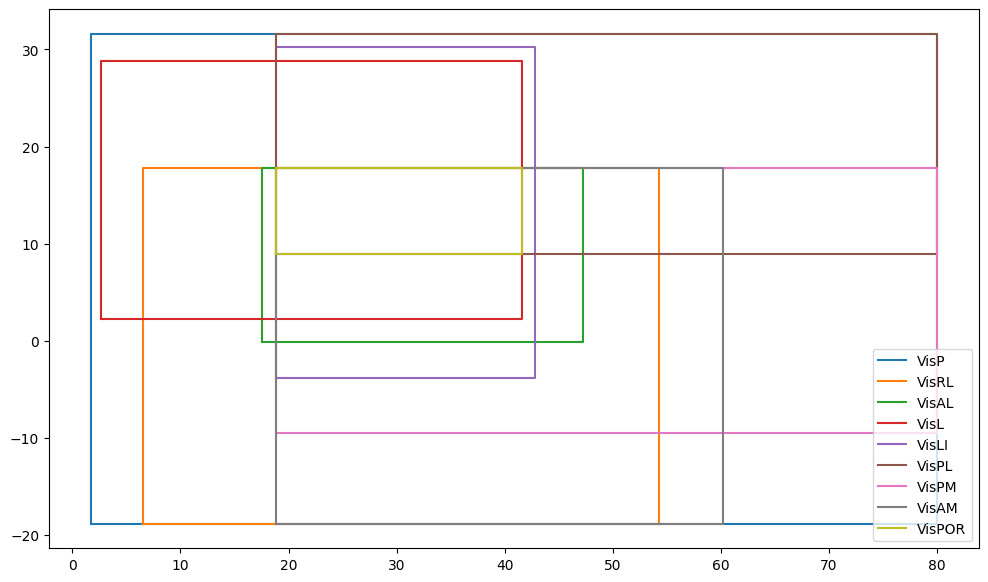

In [11]:
plot_visareas(modified_rects)


In [12]:
visP_poly = modified_rects["VisP"]
x, y = visP_poly.exterior.xy
centroid = visP_poly.centroid

width = abs(list(x)[0] - list(x)[2])
height = abs(list(y)[0] - list(y)[1])

scaled_polys = {}
for area in areas:
    poly = modified_rects[area]
    # poly = scale(poly, xfact=92/width, yfact=60/height, origin=centroid)
    scaled_polys[area] = poly

visP_poly = scaled_polys["VisP"]
x, y = visP_poly.exterior.xy
centroid = visP_poly.centroid

minX = min(list(x))
minY = min(list(y))

final_polys = {}
for area in areas:
    poly = scaled_polys[area]
    poly = translate(poly, xoff= -1*minX, yoff=-1*minY)
    # poly = translate(poly, xoff= -1*minX, yoff=0)
    final_polys[area] = poly

<Figure size 500x500 with 0 Axes>

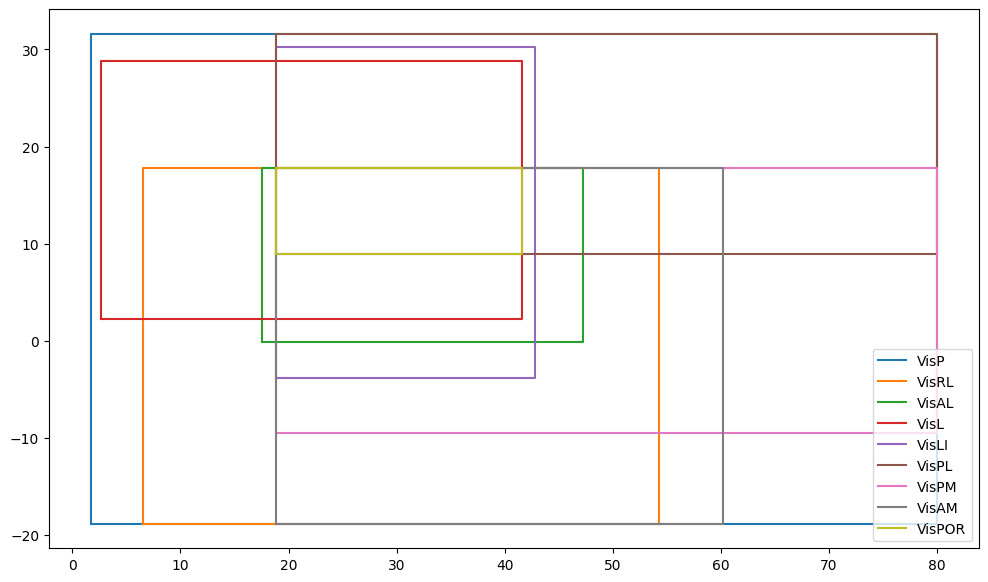

In [13]:
plt.figure(figsize=(5,5))
plot_visareas(scaled_polys)

In [14]:
import pickle
pickle.dump(final_polys, open( "retinomap.pkl", "wb" ) )

In [15]:
np.load('retinomap.pkl', allow_pickle=True)


{'VisP': <shapely.geometry.polygon.Polygon at 0x7fb1a2031b20>,
 'VisRL': <shapely.geometry.polygon.Polygon at 0x7fb1a22d8f40>,
 'VisAL': <shapely.geometry.polygon.Polygon at 0x7fb19dc9e1f0>,
 'VisL': <shapely.geometry.polygon.Polygon at 0x7fb1a2294e50>,
 'VisLI': <shapely.geometry.polygon.Polygon at 0x7fb1a2294e80>,
 'VisPL': <shapely.geometry.polygon.Polygon at 0x7fb1a0ebbc40>,
 'VisPM': <shapely.geometry.polygon.Polygon at 0x7fb1a0ebb1f0>,
 'VisAM': <shapely.geometry.polygon.Polygon at 0x7fb1a0ebb160>,
 'VisPOR': <shapely.geometry.polygon.Polygon at 0x7fb19dc9e1c0>}

In [16]:
import pandas as pd
import collections
area_xy = collections.defaultdict(list)
for area in areas:
    area_xy["name"].append(area)
    x1, y1, x2, y2 = final_polys[area].bounds
    # area_xy["x1"].append(max(x1,0.))
    # area_xy["y1"].append(max(y1,0))
    # area_xy["x2"].append(min(x2,92))
    # area_xy["y2"].append(min(y2,60))
    area_xy["x1"].append(x1)
    area_xy["y1"].append(y1)
    area_xy["x2"].append(x2)
    area_xy["y2"].append(y2)
    

area_xy_pd = pd.DataFrame(area_xy)
area_xy_pd.to_csv("retinomap.csv")